# Assessment task – word splitting

### Let's understand the simple tool created for splitting incorrectly concatenated words.

![NLP](resources/imgs/NLP.png)

Image Credit: Copyright @ 2020 Xorance Solutions Pvt. Ltd.

##  Introduction

### What are we reviewing today?

Creating a simple solution that split mistakenly concatenated words using [this](https://github.com/tuetschek/e2e-dataset/releases/download/v1.0.0/e2e-dataset.zip) dataset.This dataset was adapted to simulate word concatenation errors. Below you will find a prototype of the solution and some metrics for assesing its performance.

### What is the content of this notebook?

1. Importing required libraries
2. Loading the data into a dataframe
3. Manipulation of dataset
4. Development of solution
5. Performing predictions
6. Assesing performance with BLEU scores
7. Model optimization
8. Examples
9. Decisions Summary and Assumptions

## 1. Importing required libraries

Loading the data into a `pandas` DataFrame provides an easy way to manipulate the data. 

`wordninja` is the main library used for splitting concatenated words. It is an open-source library that uses probabilistic models to split words based on unigrams using English Wikipedia. This approach showed a high performance on the split and that's why is the main tool of this solution.

`re` is used to discover regular expresions in sentences. This helped to tuning the model provided by `wordninja`.

`nltk` is used to compute the BLEU scores of the predictions performed.

`matplotlib` is used to display few visualizations of the metrics used.

In [1]:
import pandas as pd
import wordninja
from nltk.translate.bleu_score import sentence_bleu
import re

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 2. Loading the data into a dataframe

The CSV file is loaded into a Dataframe object to analyse and manipulate its content. It contains 2 columns `mr` and `ref`. **`ref`** is the column used for developing this prototype. It contains over **4K** records which are mainly reviews of venues/restaurants written in English.

In [2]:
df = pd.read_csv("resources/data/devset.csv")
print("Size of dataset:{}".format(len(df)))
df.head(2)

Size of dataset:4672


mr  \
0  name[Alimentum], area[city centre], familyFrie...   
1  name[Alimentum], area[city centre], familyFrie...   

                                                 ref  
0  There is a place in the city centre, Alimentum...  
1  In the city centre there is a venue name Alime...

# 3. Manipulation of dataset

In real life, there are many situations that can create incorrect concatenated words. There are two most likely scenarios. First,
having sentences with few words incorrectly concatenated in any part of the text. Second, having all words in a sentence concatenated. The latter is the most complex case because it requires a full split. 

Therefore, my proposal for adapting the dataset is *to concatenate all the words of each of the sentences*. Then, to measure the performance of the splitter for this complex case. This performance will help us understand how good the model can perform in very difficult splits, which will be a useful reference for evaluating the efficiency of our proposal.  

With this in mind I created 2 concatenation types:
   1. the **`concatenated_sentence_raw`** column contains a concatenation of the raw sentences. It simply replaces all spaces and keeps punctuation and uppercasing. 
   2. the **`concatenated_sentence_preproc`** contains a concatenation of a preprocessed version of each sentence. Here Hyphens and dots are removed. This helped to get a more genuine BLEU score on the data. Its removal doesn't have a big impact on the understanding of their content either for a human or a computer.

In [3]:
df["concatenated_sentence_raw"] = df.ref.apply(lambda x: x.replace(" ",""))
df["concatenated_sentence_preproc"] = df.ref.apply(lambda x: x.replace("-","").replace(" ",""))
df[["concatenated_sentence_raw","concatenated_sentence_preproc"]].head(3)

concatenated_sentence_raw  \
0  Thereisaplaceinthecitycentre,Alimentum,thatisn...   
1  InthecitycentrethereisavenuenameAlimentum,this...   
2  Alimentumisnotafamily-friendlyplace,locatedinc...   

                       concatenated_sentence_preproc  
0  Thereisaplaceinthecitycentre,Alimentum,thatisn...  
1  InthecitycentrethereisavenuenameAlimentum,this...  
2  Alimentumisnotafamilyfriendlyplace,locatedinci...

The same manipulation is made on the **`reference_raw`** and **`reference_preproc`** columns which is a necessary step to perform the evaluation of the predictions as seen in section *`5`*. 

Below you can see a comparison of the data in both columns. Notice that in **`reference_raw`** is the word `family-friendly` and in **`reference_preproc`** are the words `family` and `friendly`.

In [4]:
df["reference_raw"] = df.ref.apply(lambda x: [x.split(" ")])
df["reference_preproc"] = df.ref.apply(lambda x: [x.replace("-"," ").replace(".","").split(" ")])
df[["reference_raw", "reference_preproc"]].head(3)

reference_raw  \
0  [[There, is, a, place, in, the, city, centre,,...   
1  [[In, the, city, centre, there, is, a, venue, ...   
2  [[Alimentum, is, not, a, family-friendly, plac...   

                                   reference_preproc  
0  [[There, is, a, place, in, the, city, centre,,...  
1  [[In, the, city, centre, there, is, a, venue, ...  
2  [[Alimentum, is, not, a, family, friendly, pla...

# 4. Development of solution

I considered 3 possible solutions:
   1. Built our own language model or dictionary: Not recommended for this case mainly because of the size of our dataset and limited time available.
   2. Use splitter of `wordninja`: **Option selected**
   3. Use splitter of `wordsegment`: Second best option for implementation. Details of this solution are not included. 

I developed solution `2`. I created a wrapper of an existing splitter available in the **`wordninja`** library (see reference [here](https://github.com/keredson/wordninja)) due to the limitation of time and data.

Using this wrapper offers a quick solution. Therefore, the main task becomes the optimization of the splitter. For instance, plugging a lexicon for rare words to the splitter.


# 5. Performing solution

The wrapper consists of one simple line of code. I made predictions for the raw and preprocessed cases. The purpose of this is to discover and select the case that performs best. The predictions are stored in the **`candidate_raw`** column for the raw sentence case and in the **`candidate_preproc`** column for the preprocessed sentence case.

As you see below the predictions are in a form of a list of tokens, where each token is a word found in the concatenated sentence. There are correct words like `There`, `is`,`a` and `city`. However, in line `2` `Alimentum` is wrongly splitted into 3 words `Ali`,`men` and `tum`, showing that the solution is not perfect.

In [5]:
#splitting words for raw case
df["candidate_raw"] = df.concatenated_sentence_raw.apply(lambda x: wordninja.split(x))
#splitting words for preprocessed case
df["candidate_preproc"] = df.concatenated_sentence_preproc.apply(lambda x: wordninja.split(x))

df[["candidate_raw","candidate_preproc"]].head(3)

candidate_raw  \
0  [There, is, a, place, in, the, city, centre, A...   
1  [In, the, city, centre, there, is, avenue, nam...   
2  [Ali, men, tum, is, not, a, family, friendly, ...   

                                   candidate_preproc  
0  [There, is, a, place, in, the, city, centre, A...  
1  [In, the, city, centre, there, is, avenue, nam...  
2  [Ali, men, tum, is, not, a, family, friendly, ...

# 6. Assesing performance with BLEU scores

I decided to use **BLEU score** as the metric of measure. A score of `1` represents a perfect prediction/split 
and a score of `0` implies a completely wrong prediction/split of words.

The `Blue score` is well-known in the Machine Translation community. It originally measures the degree of difference between human and machine translations. It can be adapted to our case for comparing the *original sentence* ( reference) and the *splitted sentence* in order to **determine how identical the original and predicted sentences are**. 


The procedure for computing BLUE score is as follows:

   1. Create a *tokenised* version of the original sentence: See **`reference_raw`** or **`reference_preproc`** in section `3`.
   2. Create the candidate/predicted split of a concatenated sentence: See **`candidate_raw`** or **`candidate_preproc`** in section `5`.
   3. Compare the reference with its corresponding candidate and get a BLEU score for each pair of sentences



**Notice that the tokenizer is crucial for the BLEU scores. It is assumed that the reference sentence is the expected output.**

In [6]:
df["bleu_score_raw"] = df.apply(lambda x: sentence_bleu(x["reference_raw"],x["candidate_raw"]), axis=1)
df["bleu_score_preproc"] = df.apply(lambda x: sentence_bleu(x["reference_preproc"],x["candidate_preproc"]), axis=1)

/Users/cortezvazquezo/opt/anaconda3/envs/coolart37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/cortezvazquezo/opt/anaconda3/envs/coolart37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Below we compare the BLEU scores of the raw and preprocessed cases. The preprocessing case is the one with better score. From now on we will work only with this data.

The BLEU score for the raw case is `0.7` compared to `0.8` for the preprocessing case. This difference is due to dot and hyphens in the sentences. Consequently, dot and hyphens were removed from the reference.

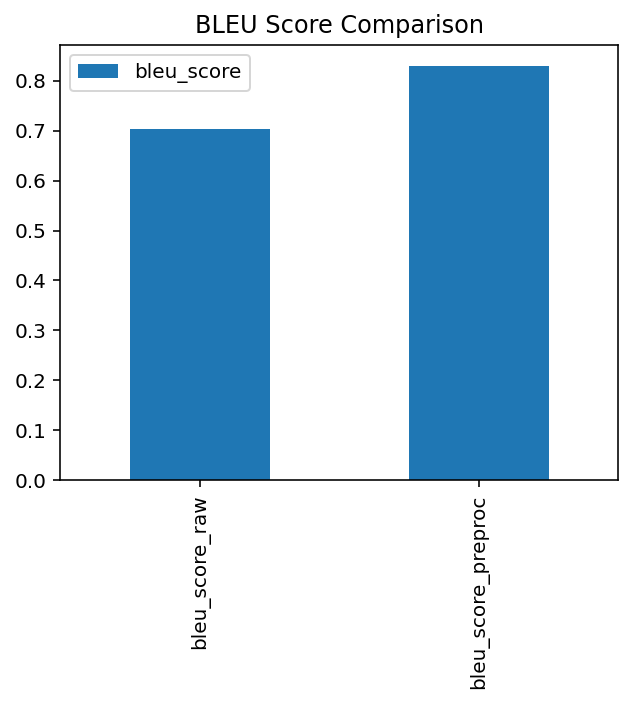

In [7]:
#create a DF to compare visually  BLEU scores of the raw and preprocessed cases
bleu_scores = {'bleu_score_raw':df.bleu_score_raw.mean(),'bleu_score_preproc':df.bleu_score_preproc.mean()}
df_bleu = pd.DataFrame(bleu_scores.items(),columns=['case','bleu_score'],index=bleu_scores.keys())
#plot BLEU scores
df_bleu.plot.bar(figsize = (5, 4),title="BLEU Score Comparison").set(xticklabels = df_bleu.case.values)
plt.show()

# 7. Model Optimization

One of the main limitations of the current solution is the wrong split of rare words (e.g., restaurant names). This type of words are usually difficult to split correctly. I proposed to use a lexicon to tackle this problem, which consequently can enhance the robustness of our model.

Names such as `Alimentum` are labeled in column `mr` of the dataset as `name`. We will create a lexicon based on all tokens in `mr` labeled as `name`, select the most critical cases and plug it to the splitter.

To create the lexicon we do the following:

   1. Extract tokens labelled as names
   2. Keep unique names
   3. Filter out common words in those names since they are likely to be sliptted properly
   
As you can see the lexicon consists of 13 words such as `Cocum`, `Alimentum` and `Fitzbillies`


In [12]:
#1. extracting names
df["tokens_lexicon"] = df.mr.apply(lambda x: re.findall(r'name\[(.*?)\]',x))
#2. keep unique names
names = {i for sublist in df.tokens_lexicon.values for i in sublist}
names

{'Alimentum',
 'Aromi',
 'Bibimbap House',
 'Browns Cambridge',
 'Clowns',
 'Cocum',
 'Cotto',
 'Fitzbillies',
 'Midsummer House',
 'Taste of Cambridge',
 'The Cambridge Blue',
 'The Cricketers',
 'The Eagle',
 'The Golden Palace',
 'The Mill',
 'The Phoenix',
 'The Punter',
 'The Wrestlers',
 'Travellers Rest Beefeater',
 'Wildwood'}

Some of the words of the original lexicon were detrimenting the performance of the model. I kept those words that improve the performance in the dataset: `Aromi`, `Cocum` and `Alimentum`.

To plug this functionality I created a dictionary for each word and its corresponding split from wordninja. This will be used to find these words in a sentence.

In [13]:
lexicon_names = [ 'Aromi','Cocum','Alimentum']
lexicon_splits = {name: wordninja.split(name) for name in lexicon_names}
lexicon_splits

{'Aromi': ['A', 'rom', 'i'],
 'Cocum': ['Co', 'cum'],
 'Alimentum': ['Ali', 'men', 'tum']}

## 7.1 Tuning Candidate Sentences using a simple lexicon

The optimisation model implies discovering matches in a sentence with those words. The tuning works as follows:

If the method `IsNameIncluded` discovers any of the words of the lexicon in the sentence, it will flag `tuneSentence` which will replace the wrong split(s) with the correct one. For instance, for `Alimentum` the tokens `Ali`,`men` and `tum` will be replaced by `Alimentum`.

This simple tunning helped improving over 2% the Bleu Score of the model as shown in section **`7.2`**.

In [14]:
def isNameIncluded(sentence,lexicon_splits):
    """
    Detecting any potential restaurant/venue name in predicted split
    :param sentence: the predicted split of a sentence as a list
    :param lexicon_splits: the dictionary with names in lexicon
    :return: a flag saying if sentence contains a name of the lexicon, the proper split of a restaurant name,
    its start and end index in the sentence list
    """
    name_start = None
    name_end = None
    name_lexicon = None
    is_included = False
    for i in sentence:
        for name in lexicon_splits.keys():
            if name.startswith(i):
                start = sentence.index(i)
                tmp_name_split = lexicon_splits[name]
                is_included = all(elem in sentence for elem in tmp_name_split)
                if is_included:
                    name_start = sentence.index(i)
                    name_end = start + len(tmp_name_split) -1
                    name_lexicon = name
    return is_included,name_lexicon,name_start,name_end

In [15]:
def tuneSentence(sentence, lexicon_splits):
    """
    Tune a sentence with correct split of restaurant/venue names if they are part of the lexicon created
    :param param sentence: the predicted split of a sentence as a list
    :param lexicon_splits: the dictionary with names in lexicon
    :return: the tuned sentence with the correct splits of restaurant/names if incorreclty splitted
    """
    name_start = None
    name_end = None
    name_lexicon = None
    is_included = False
    tuned_sentence = []
    
    is_included,name_lexicon,name_start,name_end = isNameIncluded(sentence, lexicon_splits)
    if is_included and name_lexicon is not None and name_start is not None and name_end is not None:
        tuned_sentence = [sentence[i] for i in range(0,len(sentence)) if i<= name_start or i>name_end]
        tuned_sentence[name_start] = name_lexicon
    else:
        tuned_sentence =  sentence
    return tuned_sentence

In [16]:
df["tuned_candidate"] = df.candidate_preproc.apply(lambda x:tuneSentence(x,lexicon_splits))

# 7.2 BLEU scores for tuned sentences

The tuning increased around `2%` the BLEU Score of the model, from `0.829` to `0.841`. This indicates that the optimization improved the robustness of the tool created. 

In [17]:
df["bleu_score_tuned"] = df.apply(lambda x: sentence_bleu(x["reference_preproc"],x["tuned_candidate"]), axis=1)

In [18]:
#create a DF to compare visually  BLEU scores of the raw and preprocessed cases
bleu_scores = {'bleu_score_preproc':df.bleu_score_preproc.mean(),'bleu_score_tuned':df.bleu_score_tuned.mean()}
df_bleu = pd.DataFrame(bleu_scores.items(),columns=['case','bleu_score'],index=bleu_scores.keys())
#plot BLEU scores
df_bleu

case  bleu_score
bleu_score_preproc  bleu_score_preproc    0.829424
bleu_score_tuned      bleu_score_tuned    0.841046

# 8. Examples 

Below there are few examples of the splits performed by the tuned model.

### Perfect Split 
The example below shows a perfect split with `BLEU Score = 1`.

In [19]:
samples = df.loc[df["bleu_score_tuned"] > 0.9][["reference_preproc","tuned_candidate","bleu_score_tuned"]].reset_index().drop(columns="index").values
example = samples[0]
print("Reference Split Sentence:{} \nPredicted Split Sentence:{}\n BLEU Score:{}".format(example[0][0],example[1],example[2]))

Reference Split Sentence:['Alimentum', 'is', 'not', 'a', 'family', 'friendly', 'arena', 'and', 'is', 'located', 'in', 'the', 'city', 'centre'] 
Predicted Split Sentence:['Alimentum', 'is', 'not', 'a', 'family', 'friendly', 'arena', 'and', 'is', 'located', 'in', 'the', 'city', 'centre']
 BLEU Score:1.0


### Poor Split

The example below with `0.53` BLEU Score shows one blind spot of the BLEU metric. The original sentence has the words `are` and `searching` whilst the predicted one has the words `a` and `researching`. This is a possible and likely combination, however it is wrong for this sentence. Also, context is partly missed by the model. However, this is not something BLEU score is capable of indicate. 

In [20]:
samples = df.loc[df["bleu_score_tuned"] < 0.6][["reference_preproc","tuned_candidate","bleu_score_tuned"]].reset_index().drop(columns="index").values
example = samples[0]
print("Reference Split Sentence:{} \nPredicted Split Sentence:{}\n BLEU Score:{}".format(example[0][0],example[1],example[2]))

Reference Split Sentence:['If', 'you', 'are', 'searching', 'for', 'a', 'place', 'to', 'go', "that's", 'not', 'family', 'friendly', 'and', 'near', 'the', 'riverside,', 'Alimentum', 'is', 'the', 'place', 'for', 'you'] 
Predicted Split Sentence:['If', 'you', 'a', 'researching', 'for', 'a', 'place', 'togo', "that's", 'not', 'family', 'friendly', 'and', 'near', 'the', 'riverside', 'Alimentum', 'is', 'the', 'place', 'for', 'you']
 BLEU Score:0.5379942002865987


### Limitations of the BLEU metric


One of the main limitations of BLEU is that a sentence can receive a low score if slightly changes are present. For instance, in the example below the comma that differs in `Alimentum` vs `Alimentum,` has affected the BLEU Score to `0.69`.

Removing all punctuation marks could fix this problem. 

In [21]:
samples = df.loc[(df["bleu_score_tuned"] > 0.6) & (df["bleu_score_tuned"] < 0.75)][["reference_preproc","tuned_candidate","bleu_score_tuned"]].reset_index().drop(columns="index").values
example = samples[0]
print("Reference Split Sentence:{} \nPredicted Split Sentence:{}\n BLEU Score:{}".format(example[0][0],example[1],example[2]))

Reference Split Sentence:['There', 'is', 'a', 'place', 'in', 'the', 'city', 'centre,', 'Alimentum,', 'that', 'is', 'not', 'family', 'friendly'] 
Predicted Split Sentence:['There', 'is', 'a', 'place', 'in', 'the', 'city', 'centre', 'Alimentum', 'that', 'is', 'not', 'family', 'friendly']
 BLEU Score:0.6997522298221912


# 9.  Decisions Summary and Assumptions

I proposed a prototype to solve the splitting of incorrectly concatenated words. The main decisions made for this prototype were:

    1. Adapting the dataset by concatenating all the words of each of the sentences in the given dataset to tackle the most complex case.
    2. Building a quick solution by combining a lexicon and a statistical model to perform the split of concatenated words.
    3. Using BLEU score as the metric for assesing the quality of splits.
    4. The original sentences were preprocessed by removing some of the punctuation marks like dots and hyphens. It helped to get a more genuine BLEU score.
    5. Not training a model because of the short time available and small size of the dataset. 
    6. Not creating a training and testing dataset. All samples were used for the evaluation because of the nature of the solution developed.
    
The assumptions considered were:

    1. The reference sentence is the expected output.
    2. The accuracy of words in reference is based on a word match.
    3. The sentences provided are correct. Therefore, their context and content were not relevant when measuring the splitter performance.
    4. This is not a final solution, hence more tuning,analysis and customisation would be required to implement it for a specific use case.

### A demo of this prototype can be found in the Demo folder.Please read the `README.md` file

# Thank you.